In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.utils.data as data


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Lấy dữ liệu và kiểm tra

In [3]:
import ast
# Đọc dữ liệu từ file CSV
df = pd.read_csv('data_training.csv')
    
# Chọn các cột 'x1', 'x2', 'x3', 'x4', 'x5' làm đầu vào và 'y' làm đầu ra
x_data = df[['x1', 'x2', 'x3', 'x4', 'x5']]
y_data = df['y']

# Khởi tạo danh sách để lưu trữ dữ liệu đầu vào dưới dạng tensors
x_train = []

# Lặp qua từng hàng trong x_data
for index in range(len(x_data)):
    # Lấy hàng thứ index từ DataFrame
    row = x_data.iloc[index]
    # Chuyển đổi từng giá trị trong hàng thành list
    x_values = [ast.literal_eval(val) for val in row.values]
    # Thêm tensor tương ứng vào danh sách x_train
    x_train.append(torch.tensor(x_values, dtype=torch.float32))

# Chuyển đổi dữ liệu đầu ra thành tensor PyTorch
y_train = torch.tensor(y_data.values, dtype=torch.long).to(device)

# Tạo tensor từ danh sách các tensors đầu vào
X_train = torch.stack(x_train).to(device)

# In ra kích thước của tensors đầu vào và đầu ra
print("x_train:", X_train.shape)
print("y_train:", y_train.shape)

x_train: torch.Size([26846, 5, 10])
y_train: torch.Size([26846])


### Định nghĩa các biến và tạo tập train và test

In [4]:
batch_size = 32
length = 10
num_labels = 36
num_sensors = 5

In [5]:
# Tổng số mẫu
total_samples = len(X_train)

# Trích 80% cho tập train, 20% cho tập test
train_size = int(0.8 * total_samples)
test_size = total_samples - train_size

# Chia dữ liệu thành tập tran và test
train_dataset, test_dataset = data.random_split(torch.utils.data.TensorDataset(X_train, y_train),
                                                [train_size, test_size])

# Khởi tạo DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Định nghĩa các mô hình

In [6]:
# Định nghĩa mô hình CNN 1D
class CNN1D(nn.Module):
    def __init__(self, num_sensors, num_labels, length):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_sensors, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.batch_norm3 = nn.BatchNorm1d(512)
        self.batch_norm4 = nn.BatchNorm1d(512)
        self.batch_norm5 = nn.BatchNorm1d(1024)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=1)
        self.fc1 = nn.Linear(512 * length, 512)
        self.fc2 = nn.Linear(512, num_labels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.maxpool(x)
        x = self.relu(self.batch_norm3(self.conv3(x)))
        x = self.maxpool(x)
        x = self.relu(self.batch_norm4(self.conv4(x)))
        x = self.maxpool(x)
        x = self.relu(self.batch_norm5(self.conv5(x)))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

### Huấn luyện mô hình

In [7]:
num_epochs = 100
learning_rate = 0.001

In [8]:
# Khởi tạo mô hình, hàm mất mát và bộ tối ưu
model = CNN1D(num_sensors=num_sensors, num_labels=num_labels, length=length).to(device)
error = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#model = CNN1D(num_sensors=num_sensors, num_labels=num_labels, length=length).to(device)# 7,Create CNN
#error = nn.CrossEntropyLoss()#8, Cross Entropy Loss 
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001)

In [9]:
# Danh sách các nhãn
label_dict = {'11': 0, '12': 1, '13': 2, '14': 3, '21': 4, '22': 5, '23': 6, '24': 7, '31': 8, '32': 9, '33': 10, '34': 11, '41': 12, '42': 13, '43': 14, '44': 15, '51': 16, '52': 17, '53': 18, '54': 19, '61': 20, '62': 21, '63': 22, '64': 23, '71': 24, '72': 25, '73': 26, '74': 27, '81': 28, '82': 29, '83': 30, '84': 31, '91': 32, '92': 33, '93': 34, '94': 35}

# Hàm chuyển đổi nhãn
def label_to_index(labels):
    # Chuyển đổi tensor labels về list
    labels_list = [str(label.item()) for label in labels]
    return torch.tensor([label_dict[label] for label in labels_list])

In [10]:
import os

# Kiểm tra xem file checkpoint đã tồn tại hay chưa
if os.path.exists('training_checkpoint.pth'):
    # Nếu có, tiếp tục từ checkpoint
    checkpoint = torch.load('training_checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    loss_values = checkpoint['loss_values']
    print("Đã tìm thấy checkpoint, tiếp tục huấn luyện từ epoch", start_epoch)
else:
    # Nếu không, bắt đầu huấn luyện từ đầu
    start_epoch = 0
    loss_values = []

for epoch in range(start_epoch, num_epochs):
    model.train()  # Đặt mô hình ở chế độ huấn luyện
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        labels = label_to_index(labels).to(device)
        outputs = model(inputs)
        loss = error(outputs, labels)  #Tính toán hàm tổn thất (loss function)
        loss.backward()  #Chuyền ngược
        optimizer.step()  # Cập nhật trọng số

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    loss_values.append(epoch_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")
    
        # Lưu checkpoint sau mỗi epoch
    torch.save({
       'epoch': epoch,
       'model_state_dict': model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict(),
       'loss_values': loss_values
   }, 'training_checkpoint.pth')


Đã tìm thấy checkpoint, tiếp tục huấn luyện từ epoch 100


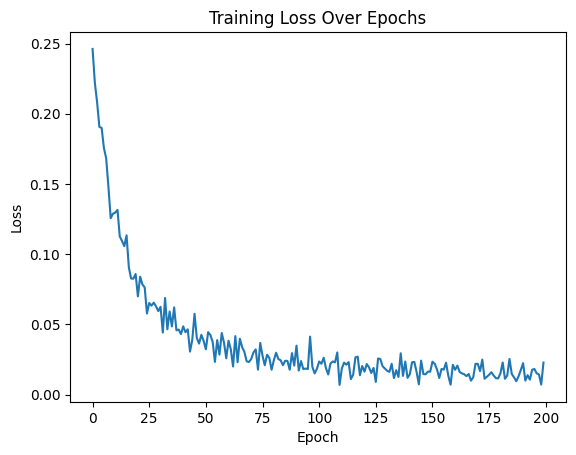

In [11]:
import matplotlib.pyplot as plt
# Đồ thị Loss
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

### Đánh giá mô hình sau huấn luyện

In [12]:
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = label_to_index(labels).to(device)
            
            outputs = model(inputs)
            loss = error(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Validation Loss: 0.0278, Validation Accuracy: 0.9976


In [13]:
import random
# Lấy một mẫu ngẫu nhiên
model.eval()  # Đặt mô hình vào chế độ đánh giá
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = label_to_index(labels).to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        print(f"True Label: {labels.item()}, Predicted Label: {predicted.item()}")
        break  # Chỉ lấy một mẫu

    # Lấy mẫu ngẫu nhiên từ toàn bộ tập dữ liệu
    random_index = random.randint(0, len(test_dataset) - 1)
    random_sample, random_label = test_dataset[random_index]
    random_sample = random_sample.unsqueeze(0).to(device)  # Thêm một chiều batch và chuyển sang device
    random_label = label_to_index([random_label]).to(device)

    random_output = model(random_sample)
    _, random_predicted = torch.max(random_output, 1)

    print(f"Random Sample - True Label: {random_label.item()}, Predicted Label: {random_predicted.item()}")

True Label: 4, Predicted Label: 4
Random Sample - True Label: 31, Predicted Label: 31


### Đánh giá mô hình ở tập testing_data